In [1]:
import pandas as pd
import json
import re
import numpy as np
import Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# import data JSON

In [2]:
with open('Dataset/Tensi_skripsi.json', 'r') as f:
    data = json.load(f)

In [3]:
data

[{'kategori': 'Greeting',
  'pertanyaan': ['baik',
   'baik-baik saja',
   'sangat baik',
   'aku baik',
   'aku baik-baik saja',
   'aku merasa baik',
   'Kabar saya baik',
   'Kabar saya baik-baik saja',
   'Saya merasa sangat baik',
   'Saya sehat-sehat saja',
   'Saya merasa baik-baik saja, terima kasih',
   'Alhamdulillah, kabar saya baik',
   'Kabar saya cukup baik',
   'Saya dalam keadaan baik',
   'Saya merasa baik dan sehat',
   'sehat',
   'sangat sehat',
   'aku merasa sehat',
   'Saya merasa sangat sehat',
   'Alhamdulillah, saya dalam keadaan sehat',
   'Kabar saya baik-baik saja, dan kesehatan saya juga baik-baik saja',
   'Saya dalam kondisi sehat',
   'Saya merasa sehat dan bugar',
   'Kondisi kesehatan saya cukup baik',
   'Saya merasa sehat dan kuat',
   'Lagi oke-oke aja nih kak',
   'tidak enak badan',
   'kurang enak badan',
   'sakit',
   'tidak sehat',
   'aku sedang tidak sehat',
   'aku kurang sehat',
   'tidak baik',
   'tidak enak badan',
   'kurang baik',
  

# Mengubah data JSON ke dalam bentuk DataFrame

Mengubah data json kedalam bentuk DataFrame 

Dataframe merupakan data yang berbentuk tabel

In [4]:
kategori = []
pertanyaan = []
jawaban={}
for intent in data:
    jawaban[intent['kategori']]=intent['jawaban']
    for lines in intent['pertanyaan']:
        pertanyaan.append(lines)
        kategori.append(intent['kategori'])
        df = pd.DataFrame({"kategori":kategori, "pertanyaan":pertanyaan})

In [5]:
#menampilkan dataframe
df

,kategori,pertanyaan
0,Greeting,baik
1,Greeting,baik-baik saja
2,Greeting,sangat baik
3,Greeting,aku baik
4,Greeting,aku baik-baik saja
...,...,...
1482,about_Amlodipine,Tolong jelaskan efek samping yang terkait deng...
1483,about_Amlodipine,Apa efek negatif yang mungkin muncul akibat am...
1484,about_Amlodipine,Saya belum mengetahui efek samping apa yang da...
1485,about_Amlodipine,Efek samping apa yang umum terjadi setelah men...


# Preprocessing Data

In [6]:
def preprocess_data(text):
    # Lowercasing
    text = text.lower()
    
    # Remove punctuation
    separator = '|'
    hapus_tandabaca = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{}~'
    delete =str.maketrans(dict.fromkeys(hapus_tandabaca,''))
    text = text.translate(delete)
    
    # Stemming
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    
    # Tokenizing
    tokens = ' '.join(stemmed_tokens).split()
    
    return tokens


In [7]:
df['pertanyaan'] = df['pertanyaan'].apply(preprocess_data)

In [8]:
# # Read file csv
# with open('savemodel/data_prep.csv', 'r') as f:
#       df = pd.read_csv(f)

In [9]:
df

,kategori,pertanyaan
0,Greeting,[baik]
1,Greeting,"[baikbaik, saja]"
2,Greeting,"[sangat, baik]"
3,Greeting,"[aku, baik]"
4,Greeting,"[aku, baikbaik, saja]"
...,...,...
1482,about_Amlodipine,"[tolong, jelas, efek, samping, yang, kait, den..."
1483,about_Amlodipine,"[apa, efek, negatif, yang, mungkin, muncul, ak..."
1484,about_Amlodipine,"[saya, belum, tahu, efek, samping, apa, yang, ..."
1485,about_Amlodipine,"[efek, samping, apa, yang, umum, jadi, telah, ..."


**Note**: Menampilkan data yang telah dilakukan text preprocessing

In [10]:
vocabs = []
for x in df["pertanyaan"]:
    for y in x:
        vocabs.append(y)

In [11]:
len(vocabs)

9486

**Note**: Berikut adalah panjang vocab secara keseluruhan yaitu sebesar 9899

In [12]:
def unique(list1):
 
    # initialize a null list
    unique_list = []
 
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

In [13]:
vocabs = unique(vocabs)
len(vocabs)

386

**Note**: dapat kita lihat berikut adalah panjang vocab setelah dilakukan pengahpusan kata yang duplikat atau kata yang lebih dari satu. Total panjang vocab menyusut menjadi 422

# MODEL

## Interpretasi Kata

In [14]:
def CVec_fit_transform(data):
    # Membuat objek CountVectorizer
    vectorizer = CountVectorizer()
    # Mengubah data tokenized menjadi bentuk numerik dengan menggunakan fit_transform
    data_numerik = vectorizer.fit_transform(data.apply(lambda x: " ".join(x)))
    return pd.DataFrame(data_numerik.toarray(), columns=vectorizer.get_feature_names_out()), vectorizer

**note**: pada fungsi CVec_fit_transform menggunakan fit_transform. dimana fit berfungsi untuk Menghitung frekuensi kata-kata dalam data dan menentukan daftar unik kata-kata, dan transform kemudian merubah setiap kata yang ada menjadi numerik.

In [15]:
def CVec_transfrom(data, countVec):
      data_numerik = countVec.transform(data.apply(lambda x: " ".join(x)))
      return pd.DataFrame(data_numerik.toarray(), columns=countVec.get_feature_names_out())

*note*: sedangkan pada fungsi CVec_transfrom yaitu menggunakan transform. dimana berfungsi untuk merubah data teks menjadi data numerik.

In [16]:
# Memanggil fungsi CVec_fit_transform untuk melakukan proses merubah kata ke dalam bentuk numerik
X, CVec = CVec_fit_transform(df["pertanyaan"])

In [17]:
X

,ada,adalah,agar,aja,akhirakhir,akibat,aktifitas,aktivitas,aku,alami,...,up,usia,utama,wah,waktu,walafiat,waspada,ya,yaa,yang
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1483,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1484,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1485,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


##  Naive Bayes

In [18]:
# Memisahkan data numerik (fitur) dan label
X, CVec = CVec_fit_transform(df['pertanyaan'])
y = df['kategori']

# Melakukan split data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [105]:
class MultinomialNaiveBayes:
    def __init__(self):
        self.classes = None
        self.prior_probs = None
        self.likelihood_probs = None
    
    def calculate_prior_probability(self, y):
        classes, class_counts = np.unique(y, return_counts=True)
        prior_probs = {}
        total_instances = len(y)
        for class_label, class_count in zip(classes, class_counts):
            prior_probs[class_label] = class_count / total_instances
        return prior_probs
    
    def calculate_likelihood(self, X, y):
        classes, class_counts = np.unique(y, return_counts=True)
        likelihood_probs = {}
        num_features = X.shape[1]
        for class_label, class_counts in zip(classes, class_counts):
            class_instances = X[y == class_label]
            feature_counts = np.sum(class_instances, axis=0)
            total_counts = np.sum(feature_counts)
            likelihood_probs[class_label] = (feature_counts + 1) / (total_counts + num_features)
        return likelihood_probs
    
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.prior_probs = self.calculate_prior_probability(y)
        self.likelihood_probs = self.calculate_likelihood(X, y)
    
    def predict(self, X):
        predictions = []
        for instance in X:
            instance_probs = []
            for class_label in self.classes:
                class_prob = np.log(self.prior_probs[class_label])
                likelihood_probs = self.likelihood_probs[class_label]
                instance_prob = np.sum(np.log(likelihood_probs) * instance)
                instance_probs.append(class_prob + instance_prob)
            predicted_class = self.classes[np.argmax(instance_probs)]
            predictions.append(predicted_class)
        return predictions

In [106]:
# Membuat objek MultinomialNaiveBayes
naive_bayes = MultinomialNaiveBayes()
# Melatih model menggunakan data pelatihan
naive_bayes.fit(X_train, y_train)

## Uji Coba  prediksi dengan menggunakan sebuah pertenayaan

In [107]:
# Menentukan input yang akan diuji
test_question = "apa sih tensibot "

# Melakukan preprocessing pada input yang akan diuji
test_question1 = preprocess_data(test_question)

# Mengubah input yang akan diuji menjadi bentuk yang dapat digunakan oleh algoritma Multinomial Naive Bayes
test_question1 = CVec_transfrom(pd.Series([test_question1]), CVec)

# Mengklasifikasikan input berdasarkan model yang telah dibuat
prediction = naive_bayes.predict(test_question1.values)

# Mengambil hasil klasifikasi (kelas prediksi)
predicted_class = prediction[0]

# Mendapatkan jawaban dari DataFrame berdasarkan kelas prediksi
# Cari jawaban yang sesuai berdasarkan hasil prediksi kategori
for item in data:
    if item["kategori"] == predicted_class:
        output_jawaban = item["jawaban"]
        break
else:
    output_jawaban = "Kategori jawaban tidak ditemukan."


# Menampilkan hasil klasifikasi
print ("hasil Prediksi dari kalimat:======", test_question,"============\n")
print ("dengan hasil counvectorizer sebagai berikut\n")
print(test_question1,"\n")
print("Hasil klasifikasi/prediksi:", prediction[0],"\n")
print("Jawaban:", output_jawaban)


hasil Prediksi dari kalimat:====== apa sih tensibot  ============

dengan hasil counvectorizer sebagai berikut

   ada  adalah  agar  aja  akhirakhir  akibat  aktifitas  aktivitas  aku  \
0    0       0     0    0           0       0          0          0    0   

   alami  ...  up  usia  utama  wah  waktu  walafiat  waspada  ya  yaa  yang  
0      0  ...   0     0      0    0      0         0        0   0    0     0  

[1 rows x 386 columns] 

Hasil klasifikasi/prediksi: info_tensibot 

Jawaban: Tensibot merupakan sistem chatbot. chatbot ini dapat membantu kamu untuk mendiagnosa dan memberikan penanganan untuk penyakit hipertensi, Tensibot sendiri dibuat oleh Zaki Rusydi. 
Apakah ada yang kakak ingin tanyakan lagi seputar tensibot atau hipertensi?


**Note** : Dari hasil prediksi kata "apa sih tensibot", dimana sebelumnya melakukan proses tranform terlebih dahulu. dari hasil transform data kemudian dilakukanlah proses kalsifikasi atau prediksi yang terdapat di dalam class multinomial naive bayes. hasil prediksi atau klasifikasi yang di dapatkan yaitu kalimat "apa sih tensibot" termasuk kedalam label/kategori "info_tensibot". hasil dari klasifikasi tersebut sudah sesuai dengan data yang ada

In [30]:
def calculate_metrics(y_true, y_pred, classes):
    metrics = {}
    
    for class_label in classes:
        tp = 0
        fp = 0
        fn = 0
        
        for i in range(len(y_true)):
            if y_true[i] == y_pred[i]:
                if y_true[i] == class_label:
                    tp += 1
            else:
                if y_true[i] == class_label:
                    fn += 1
                else:
                    fp += 1
        
        precision = tp / (tp + fp) if (tp + fp) != 0 else 0
        recall = tp / (tp + fn) if (tp + fn) != 0 else 0
        f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
        
        metrics[class_label] = {
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1_score
        }
    
    return metrics

In [32]:
# Membuat objek MultinomialNaiveBayes
naive_bayes = MultinomialNaiveBayes()

# Melatih model menggunakan data pelatihan
naive_bayes.fit(X_train.values, y_train.values)

# Melakukan prediksi pada data uji
y_pred = naive_bayes.predict(X_test.values)

# Menghitung metrik precision, recall, dan F1-score
metrics = calculate_metrics(y_test.values, y_pred, naive_bayes.classes)

# Menampilkan hasil akurasi, precision, recall, dan F1-score
for class_label, class_metrics in metrics.items():
    print(f"Class: {class_label}")
    print(f"Precision: {class_metrics['Precision']}")
    print(f"Recall: {class_metrics['Recall']}")
    print(f"F1-Score: {class_metrics['F1-Score']}")
    print()

Class: Greeting
Precision: 0.7692307692307693
Recall: 1.0
F1-Score: 0.8695652173913044

Class: about_Amlodipine
Precision: 0.875
Recall: 0.9824561403508771
F1-Score: 0.9256198347107438

Class: about_Catopril
Precision: 0.8181818181818182
Recall: 0.9
F1-Score: 0.8571428571428572

Class: about_Hidroclorthiazide
Precision: 0.8545454545454545
Recall: 0.9791666666666666
F1-Score: 0.912621359223301

Class: bye
Precision: 0.7142857142857143
Recall: 0.9523809523809523
F1-Score: 0.8163265306122449

Class: cek_tekanan_darah
Precision: 0.7096774193548387
Recall: 1.0
F1-Score: 0.8301886792452831

Class: info_hipertensi
Precision: 0.8688524590163934
Recall: 0.9814814814814815
F1-Score: 0.9217391304347826

Class: info_tensibot
Precision: 0.8292682926829268
Recall: 0.9444444444444444
F1-Score: 0.883116883116883



In [33]:
# Evaluasi akurasi
accuracy = np.mean(y_pred == y_test)
print("Akurasi model from scratch: ", accuracy)
# ================================================================================
from sklearn.naive_bayes import MultinomialNB

# Membuat objek MultinomialNB
modellb = MultinomialNB()
# Melatih model dengan data latih
modellb.fit(X_train, y_train)
#Menguji model dengan data uji
lb_pred = modellb.predict(X_test)
# Menampilkan hasil akurasi
print("Akurasi model library: ", accuracy_score(y_test, lb_pred))

Akurasi model from scratch:  0.9697986577181208
Akurasi model library:  0.9697986577181208


## Visualisasi

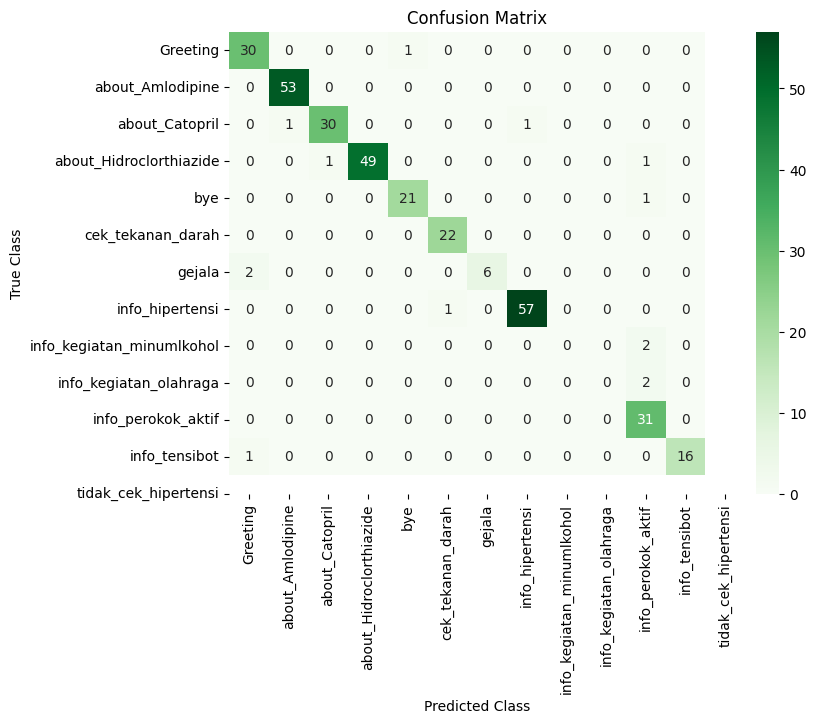

In [ ]:
# Menghitung confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Membuat plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Greens", fmt="d", xticklabels=naive_bayes.classes, yticklabels=naive_bayes.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()


**Note**: Kode program diatas berfungai untuk memahami kinerja dari model multinomial naive bayes, dimana data yang berbentuk diagonal atau berada di dalam diagonal merupakan data yang diklasifikasikan dengan benar, sedangkan data yang berada diluar digonal merupakan data yang diklasifikasikan salah

In [ ]:
import joblib
joblib.dump(CVec, 'CVec.pkl')


['CVec.pkl']

In [ ]:
# save data hasil preprocessing
df.to_csv("data_prep.csv", index=False)

In [ ]:
# save data X
X.to_csv("data_prep.csv", index=False)

In [ ]:
import pickle

# Menampilkan isi dari 
with open('./savemodel/CVec.pkl', 'rb') as file:
    trained_model = pickle.load(file)

# Print the contents of the trained model
print(trained_model)

CountVectorizer()


## Save Model 2

In [ ]:
# # Contoh penggunaan:
# naive_bayes = MultinomialNaiveBayes()
# naive_bayes.fit(X_train.values, y_train.values)

# # Menyimpan model
# save_model(naive_bayes, "multinomial_naive_bayes_model.npz")

# # Memuat kembali model
# loaded_naive_bayes = load_model("multinomial_naive_bayes_model.npz")

# # Melakukan prediksi dengan model yang dimuat kembali
# y_pred_loaded = loaded_naive_bayes.predict(X_test.values)

In [ ]:
# y_pred_loaded

In [ ]:
# # Menampilkan classification report
# print(classification_report(y_test, y_pred))
# def save_model(model, filename):
#     model_data = {
#         "classes": model.classes,
#         "prior_probs": model.prior_probs,
#         "likelihood_probs": model.likelihood_probs
#     }
#     np.savez(filename, **model_data)

# def load_model(filename):
#     loaded_data = np.load(filename, allow_pickle=True)  # Set allow_pickle=True
#     classes = loaded_data["classes"]
#     prior_probs = loaded_data["prior_probs"].item()
#     likelihood_probs = loaded_data["likelihood_probs"].item()
    
#     model = MultinomialNaiveBayes()
#     model.classes = classes
#     model.prior_probs = prior_probs
#     model.likelihood_probs = likelihood_probs
    
#     return model